We recently launched a new measure of [seven day prescribing for long term conditions](https://openprescribing.net/measure/seven_day_prescribing/all-england/) where we found variation across the country. In the background we state that there is no consensus on duration of long term prescriptions and guidance varies throughout the country around stable long term prescriptions. Most CCGs will have some form of guidance generally for one, two or three months. 

The University of Bristol have produced a [policy briefing](https://www.bristol.ac.uk/policybristol/policy-briefings/repeat-prescription-costs/) arguing that three month repeat prescriptions are more cost-effective. They base this on a systematic review and studies in CPRD. 

I have had a quick skim of the systematic review (based exclusively on American data) and the CPRD study. The policy briefing states that _current guidance to issue 28-day repeat prescriptions_. This deviates from the DataLab assertion in the seven days measure that there is no consensus. Martin, Payne and Wilson study is is based on old guidance from a handful of areas. This notebook seeks to ascertain what the variation is in 28 v 56 v 84 across the country for our basket of medicines commonly prescribed once daily for long term conditions on the complete prescribing dataset for England.

In [23]:
##importing libraries that are needed to support analysis
import pandas as pd
import numpy as np
import plotly.express as px
from ebmdatalab import bq, maps, charts
import matplotlib.pyplot as plt
import os

In [24]:
### here we extract data for modelling on a basket based on seven days measure
sql = '''
SELECT
  pct,
  quantity_per_item,
  sum(items) as items
FROM
 ebmdatalab.hscic.raw_prescribing_normalised AS presc
INNER JOIN hscic.ccgs AS ccgs ON presc.pct=ccgs.code AND ccgs.org_type='CCG'

WHERE
(bnf_code LIKE "0205051R0%" OR  ##ramipril
bnf_code LIKE "0212000B0%" OR ##atorvastatin
bnf_code LIKE "0212000Y0%" OR ##simvastatin
bnf_code LIKE "0602010V0%" OR ##levothyroxine
bnf_code LIKE "0206020A0%") ##amlodipine
AND
(bnf_name LIKE '%_Tab%' or bnf_name LIKE '%_Cap%') ##this restricts to tablets or capsules
AND (month BETWEEN '2018-12-01'
    AND '2019-11-01')

GROUP BY
  pct,
  quantity_per_item
    '''

df_ltc = bq.cached_read(sql, csv_path=os.path.join('..','data','ltc_qty.csv'))
df_ltc.head(10)

,pct,quantity_per_item,items
0,01C,18,31
1,01C,8,142
2,01C,252,9
3,01C,42,592
4,01C,9,18
5,01C,40,23
6,01C,2,96
7,01C,60,127
8,01C,20,151
9,01C,140,26


In [25]:
df_rx_repeat = df_ltc.copy()
df_rx_repeat["total_quantity"] = df_rx_repeat["quantity_per_item"]*df_rx_repeat["items"] 
df_rx_repeat.tail(5)

,pct,quantity_per_item,items,total_quantity
18065,10L,98,1,98
18066,10L,93,1,93
18067,10V,92,1,92
18068,10X,256,1,256
18069,11J,125,1,125


In [26]:
df_rx_repeat.describe()

,quantity_per_item,items,total_quantity
count,18070.000000,1.807000e+04,1.807000e+04
mean,86.223907,8.838701e+03,3.014104e+05
std,129.620874,6.954000e+04,2.313961e+06
min,1.000000,1.000000e+00,6.000000e+00
25%,24.000000,3.000000e+00,1.620000e+02
50%,52.000000,1.200000e+01,5.840000e+02
75%,103.000000,5.900000e+01,2.268000e+03
max,8400.000000,2.297582e+06,6.433230e+07


There is a maximum of 8400 on a single...... That is 23 years worth of tablets, lets investigate further below.

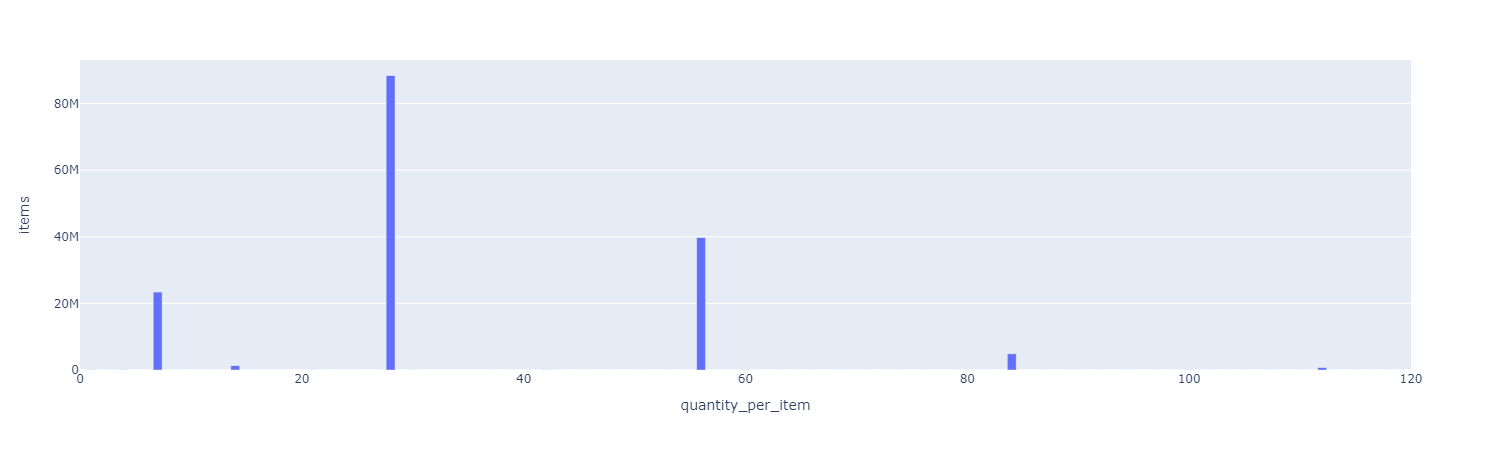

In [27]:

dfp = df_rx_repeat.copy()
dfp = dfp.groupby(["quantity_per_item"]).sum().reset_index()

fig = px.bar(dfp, x='quantity_per_item', y='items')
fig.update_xaxes(range=[0, 120])


fig.show()

In [28]:
###here we make a list of durations we want to affect for later filtering
lst = [7,28,56,84]

In [29]:
df_common = df_rx_repeat.loc[(df_rx_repeat["quantity_per_item"].isin(lst))]

print(df_common)                                                             

       pct  quantity_per_item   items  total_quantity
39     02D                  7   45410          317870
40     02D                 84    1234          103656
48     02E                  7   16427          114989
49     02E                 28  294446         8244488
50     02E                 56  159558         8935248
...    ...                ...     ...             ...
15637  11J                  7  103802          726614
15638  11J                 56  615191        34450696
15641  11J                 84   57477         4828068
15667  99M                 28  184156         5156368
15670  99M                 84   19764         1660176

[764 rows x 4 columns]


In [30]:
total = df_common["total_quantity"].sum()
df_common["proportion_of_qty"] = df_common["total_quantity"]/total*100
df_common.head(5)

<ipython-input-30-bc6469f1379d>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,pct,quantity_per_item,items,total_quantity,proportion_of_qty
39,02D,7,45410,317870,0.006032
40,02D,84,1234,103656,0.001967
48,02E,7,16427,114989,0.002182
49,02E,28,294446,8244488,0.156462
50,02E,56,159558,8935248,0.169572


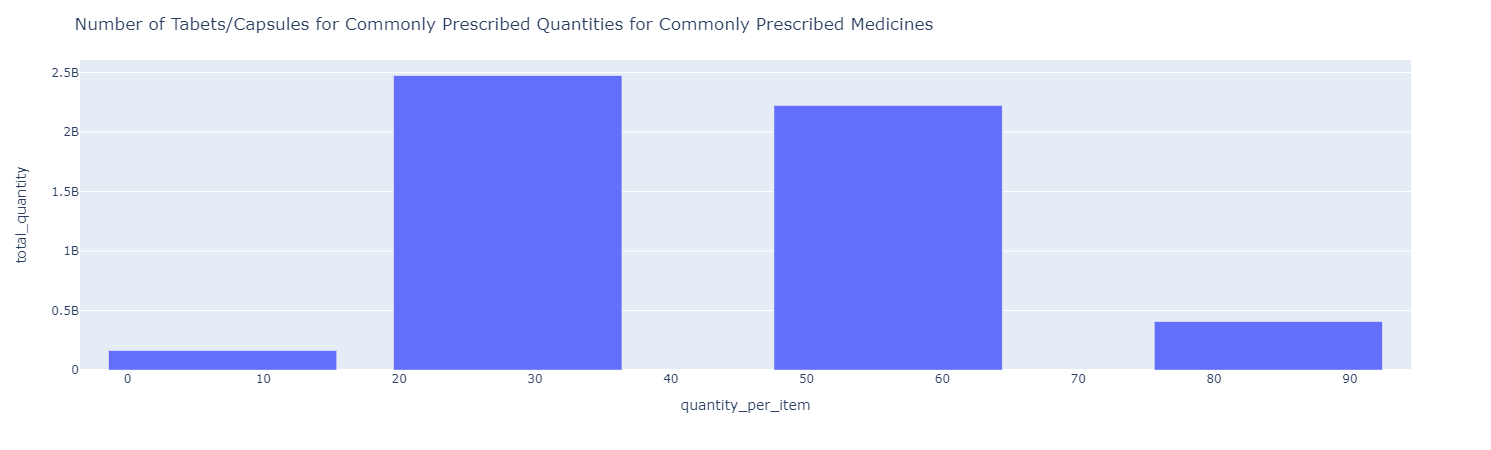

Tablets/capsules for common LTC medicines are most commonly being dispensed on 28 day prescriptions (47.0%) with approximately 42.2% being dispensed on two-monthly scripts. Only 7.7% of these common medicines are being supplied on three-monthly prescriptions.


In [31]:
dfp = df_common.copy()
dfp = dfp.groupby(["quantity_per_item"]).sum().reset_index()

fig = px.bar(dfp, x='quantity_per_item', y='total_quantity')
fig.update_layout(
    title="Number of Tabets/Capsules for Commonly Prescribed Quantities for Commonly Prescribed Medicines")
fig.show()

# get value for percentage dispensed in each of 1/2/3 months prescriptions: 
percentage = {}
for d in lst:
    percentage[d] = dfp.loc[dfp["quantity_per_item"]==d,'proportion_of_qty'].item()

print(f"Tablets/capsules for common LTC medicines are most commonly being dispensed on 28 day prescriptions ({percentage[28]:.1f}%)",
      f"with approximately {percentage[56]:.1f}% being dispensed on two-monthly scripts.",
      f"Only {percentage[84]:.1f}% of these common medicines are being supplied on three-monthly prescriptions." )


The Bristol paper assertion that most prescribing is 28 days (just about) is correct based on our basket of common LTC medicines. They recommend three-month presctiptions as being more cost effective. Now let's look at script volume to see what the workload implications might be for our basket of common medicines.

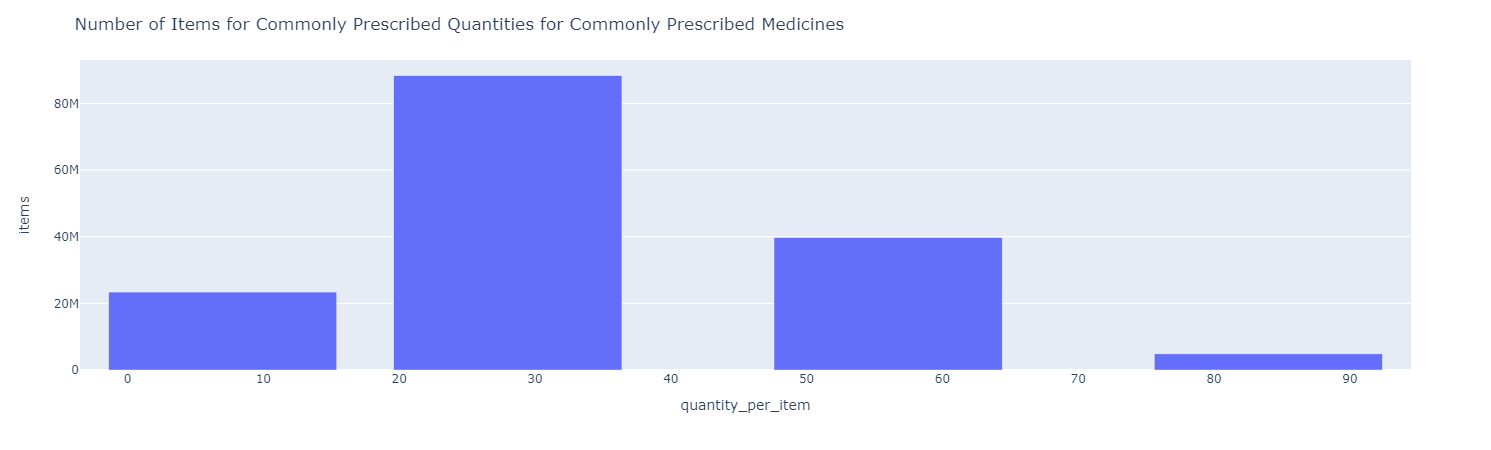

There are 88.4M one-month scripts for our basket of common medicines. There will be a substantial number of prescriptions that need amending.


In [32]:
fig = px.bar(dfp, x='quantity_per_item', y='items')
fig.update_layout(
    title="Number of Items for Commonly Prescribed Quantities for Commonly Prescribed Medicines")
fig.show()

items_28d = dfp.loc[dfp["quantity_per_item"]==28,'items'].item()/1E6
print(f'There are {items_28d:,.1f}M one-month scripts for our basket of common medicines. There will be a substantial number of prescriptions that need amending.')

This basket is based on once daily medicines - however now we know the proportions we can include twice/thrice daily medicines for medicines that are for long-term conditions which relatively stable dosing patterns. The twice/thrice is quantity repeat should be standardised around the same amount. To do this let us review the top 50 medicines dispensed last year based on tab/caps volume. 

In [33]:
sql2='''
SELECT
pct,
bnf.chemical,
bnf.chemical_code,
SUM(items) AS total_items,
SUM(total_quantity) AS total_tabs_caps
FROM
  ebmdatalab.hscic.raw_prescribing_normalised AS presc
INNER JOIN
  hscic.bnf as bnf
ON
  presc.bnf_code=bnf.presentation_code
WHERE
(presentation LIKE '%_Tab%' or presentation LIKE '%_Cap%')
    AND SUBSTR(bnf_code,0,2) IN ('01','02','04','06') ## here we use common BNF chapters. Chapter 3 resp is excluded due to amount of inhalers. ch5 is antibiotics
AND (month BETWEEN '2018-12-01'
    AND '2019-11-01')
    
GROUP BY
pct, bnf.chemical, bnf.chemical_code
ORDER BY
total_tabs_caps DESC
'''

df_ltc_raw = bq.cached_read(sql2, csv_path=os.path.join('..','data','df_ltc_raw .csv'))
df_ltc_raw .head(10)

,pct,chemical,chemical_code,total_items,total_tabs_caps
0,15M,Paracetamol,0407010H0,466322,69107602
1,15N,Paracetamol,0407010H0,499850,67502353
2,15E,Metformin Hydrochloride,0601022B0,464973,51957468
3,15E,Paracetamol,0407010H0,387416,49715687
4,13T,Paracetamol,0407010H0,411359,46461080
5,15E,Co-Codamol (Codeine Phos/Paracetamol),0407010F0,353725,40204926
6,15N,Omeprazole,0103050P0,957962,38073060
7,15C,Paracetamol,0407010H0,313331,36880068
8,15N,Metformin Hydrochloride,0601022B0,428195,36868913
9,15F,Paracetamol,0407010H0,292166,36274356


In [34]:
df_ltc_for_filter = df_ltc_raw.groupby(["chemical", "chemical_code"])["total_items","total_tabs_caps"].sum().reset_index().sort_values("total_tabs_caps", ascending=False)
df_ltc_for_filter.head()

<ipython-input-34-ebfe54dd6876>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,chemical,chemical_code,total_items,total_tabs_caps
362,Paracetamol,0407010H0,16384395,2078005085
284,Metformin Hydrochloride,0601022B0,22212640,1960904789
107,Co-Codamol (Codeine Phos/Paracetamol),0407010F0,15014107,1722100562
42,Atorvastatin,0212000B0,45389270,1468340142
342,Omeprazole,0103050P0,31550342,1207641773


In [35]:
if "GITHUB_WORKSPACE" not in os.environ:  ## this prevents a csv error during tests
    df_ltc_for_filter.to_csv(os.path.join('..','data','df_ltc_for_filter.csv'))

(shortlist exported for manual filtering)

In [36]:
df_filtered = pd.read_csv(os.path.join('..','data','filtered.csv'))
df_filtered.head()

,chemical,chemical_code,total_items,total_tabs_caps,ltc_stablish
0,Paracetamol,0407010H0,16384395,2078005085,0.0
1,Metformin Hydrochloride,0601022B0,22212640,1960904789,1.0
2,Co-Codamol (Codeine Phos/Paracetamol),0407010F0,15014107,1722100562,0.0
3,Atorvastatin,0212000B0,45389270,1468340142,1.0
4,Omeprazole,0103050P0,31550342,1207641773,0.0


In [37]:
count1 = df_filtered.chemical.nunique()
count2 = df_filtered.loc[(df_filtered["ltc_stablish"] == 1.0)].chemical.nunique()

print (f"Out of {count1} chemicals, "
       f"we have selected {count2} "
       "for our basket")

Out of 525 chemicals, we have selected 27 for our basket


## Data for Cost Modelling
**Note: to use this for cost modelling will also need to include the net_cost field in SQL query.**

In [38]:
data_cost_prep = df_ltc_raw.merge(df_filtered[['chemical_code', 'ltc_stablish']], how="outer", on="chemical_code")
data_cost_prep.head(2)

,pct,chemical,chemical_code,total_items,total_tabs_caps,ltc_stablish
0,15M,Paracetamol,0407010H0,466322.0,69107602.0,0.0
1,15N,Paracetamol,0407010H0,499850.0,67502353.0,0.0


In [39]:
data_cost_model = data_cost_prep.loc[(data_cost_prep["ltc_stablish"] == 1.0)]
if "GITHUB_WORKSPACE" not in os.environ:  ## this prevents a csv error during tests
    data_cost_model.to_csv(os.path.join('..','data','data_cost_model.csv'))
data_cost_model.head(2)

,pct,chemical,chemical_code,total_items,total_tabs_caps,ltc_stablish
316,15E,Metformin Hydrochloride,0601022B0,464973.0,51957468.0,1.0
317,15N,Metformin Hydrochloride,0601022B0,428195.0,36868913.0,1.0


## CCG Variation

CCG variation and maps based on small basket

In [40]:
df_ccg = df_ltc.groupby(['pct','quantity_per_item'])['items'].sum().reset_index()
df_ccg["total_quantity"] = df_ccg["quantity_per_item"]*df_ccg["items"] 
df_ccg.tail(5)

,pct,quantity_per_item,items,total_quantity
18065,99N,300,7,2100
18066,99N,336,11,3696
18067,99N,350,8,2800
18068,99N,365,2,730
18069,99N,565,1,565


In [41]:
df_common_ccg = df_ccg.loc[(df_ccg["quantity_per_item"].isin(lst))]

In [42]:
ccg_total = df_common_ccg.groupby(["pct"]).sum().reset_index()
ccg_total=ccg_total.rename(columns = {'total_quantity':'basket_qty'}).drop(columns =['quantity_per_item', 'items']) ##we don't need two columns
ccg_total.head()

,pct,basket_qty
0,00C,10221141
1,00D,33610164
2,00J,24694509
3,00K,32781721
4,00L,36852522


In [43]:
ccg_map =  pd.merge(df_common_ccg,ccg_total, on="pct")  
ccg_map["proportion_of_basket"] = ccg_map["total_quantity"]/ccg_map["basket_qty"]*100
ccg_map.head()

,pct,quantity_per_item,items,total_quantity,basket_qty,proportion_of_basket
0,00C,7,129771,908397,10221141,8.887432
1,00C,28,89288,2500064,10221141,24.459735
2,00C,56,117263,6566728,10221141,64.246526
3,00C,84,2928,245952,10221141,2.406307
4,00D,7,432700,3028900,33610164,9.011857


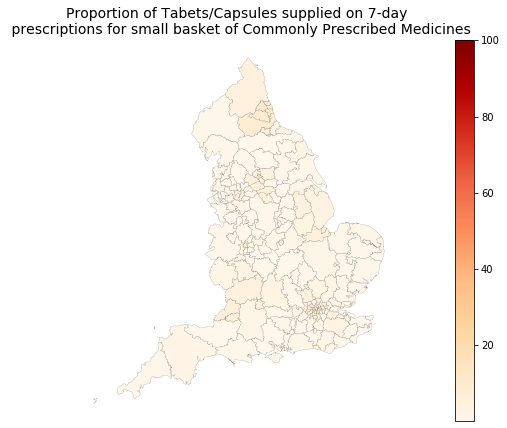

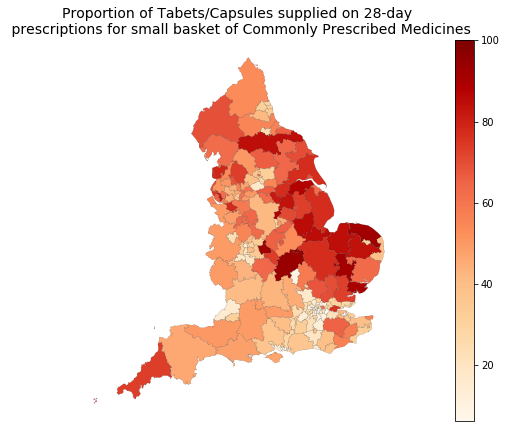

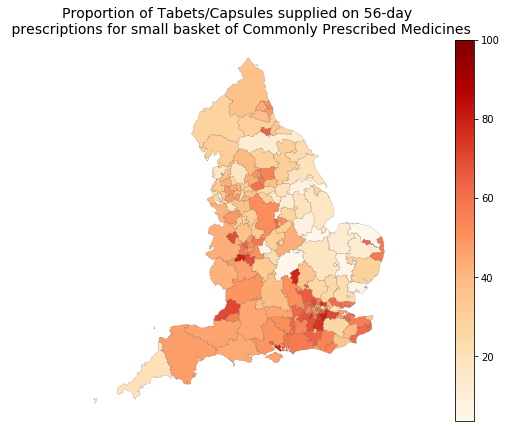

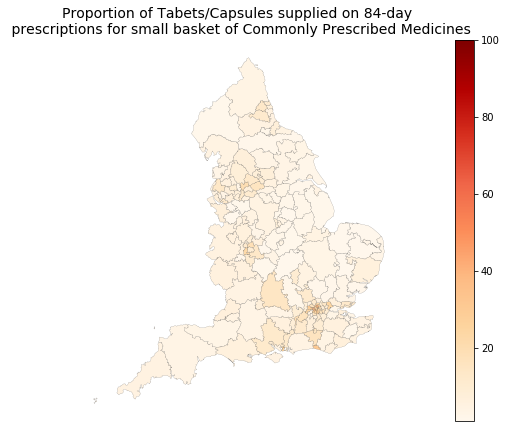

In [44]:
for quantity_per_item in ccg_map.quantity_per_item.unique():
    plt.figure(figsize=(20, 7))
    maps.ccg_map(
        ccg_map[ccg_map['quantity_per_item'] == quantity_per_item], 
        title= (f"Proportion of Tabets/Capsules supplied on {quantity_per_item}-day \n prescriptions for small basket of Commonly Prescribed Medicines"),
        column='proportion_of_basket', 
        separate_london=False,
        plot_options={'vmax': 100}
    )
    plt.show()

My impression is that the 28 day supply map looks similar to SystmOne v EMIS Web [map of deployment](https://github.com/ebmdatalab/jupyter-notebooks/blob/master/General%20Practice%20EHR%20Deployment/EHR%20Deployment.ipynb)